### 무신사 크롤링하기

In [61]:
# 필요 라이브러리 가져오기
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
import requests
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
from matplotlib import rcParams,font_manager,rc
font_path = 'C:/Windows/Fonts/NanumGothicCoding.ttf' #나눔고딕코딩체
font_name = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름 조회
rc('font',family=font_name) # 한글깨짐 현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스가 표시가 깨지는 걸 방지

In [85]:
driver = webdriver.Chrome()
driver.get('https://www.musinsa.com/categories/item/001005?d_cat_cd=001005&brand=&list_kind=small&sort=pop_category&sub_sort=&page=2&display_cnt=90&exclusive_yn='\
           + '&sale_goods=&timesale_yn=&ex_soldout=&plusDeliveryYn=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure=')

In [4]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

In [5]:
# 타이틀을 가지고 있는 클래스
pro_title = soup.select('.img-block')


##타이틀
# [i]['title']

In [6]:
pro_title_list = []
for title in pro_title:
    pro_title_list.append(title['title'])


In [7]:
len(pro_title_list)

90

In [8]:
## 브랜드
pro_brand = soup.select('.item_title > a')

## 정확한 브랜드 위치
# [i].text

In [45]:
## 페이지 바꾸는 함수
def musinsa_data(page):
    url = f'https://www.musinsa.com/categories/item/001005?d_cat_cd=001005&brand=&list_kind=small&sort=sale_high&sub_sort=1y&page={page}&display_cnt=90&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&plusDeliveryYn=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    return url

In [46]:
## 크롤링 한 데이터를 df로 만드는 함수
def product_data(page):
    url = musinsa_data(page=page)
    # url로 페이지 소스 가져오기
    reponse = requests.get(url)
    soup = BeautifulSoup(reponse.text,'lxml')
    # 전체를 담을 리스트 생성
    prod_list = []


    # 제품명 리스트
    pro_title = soup.select('.img-block')
    # 브랜드 리스트
    pro_brand = soup.select('.item_title > a')
    # 가격 리스트
    pro_price = soup.select('.price')

    for index in range(0,len(pro_title)):
        ## 제품명
        name = pro_title[index]['title']

        ## 브랜드
        brand = pro_brand[index].text

        ## 상품 가격
        non_sale = int(pro_price[index].text.split('원')[0].strip().replace(',',''))

        ## 세일 가격
        try:
            sale = int(pro_price[index].text.split('원')[1].strip().replace(',',''))
        except:
            sale = ''

        dict = {'제품명': name,'브랜드':brand,'상품 가격':non_sale,'세일 가격':sale}
        prod_list.append(dict)

        


    time.sleep(5)

    ##  리스트를 반환하기
    return prod_list

In [179]:
## 크롤링 한 데이터를 df로 만드는 함수
def product_data(page):
    url = musinsa_data(page=page)
    # url로 페이지 소스 가져오기
    reponse = requests.get(url)
    soup = BeautifulSoup(reponse.text,'lxml')
    # 전체를 담을 리스트 생성
    prod_list = []


    # 제품명
    pro_title_list = []
    for title in pro_title:
        pro_title_list.append(title['title'])

    ## 브랜드
    pro_brand = soup.select('.item_title > a')
    pro_brnad_list = []
    for brand in pro_brand:
        pro_brnad_list.append(brand.text)

    ## 상품 가격
    pro_price = soup.select('.price')
    pro_price[0].text.replace('\n','').strip().replace('원','')

    pro_price_list = []
    for price in pro_price:
        pro_price_list.append(price.text.replace('\n','').strip().replace('원',''))

    ## 세일 안하는 가격
    pro_pirce_list_non_sale = []
    for price in pro_price_list:
        pro_pirce_list_non_sale.append(int(price.split('                ')[0].replace(',','')))

    ## 세일 하는 가격
    pro_price_list_on_sale = []
    for price in pro_price_list:
        try:
            pro_price_list_on_sale.append(int(price.split('                ')[1].replace(',','')))
        except:
            pro_price_list_on_sale.append('')
    time.sleep(5)

    ##  리스트를 반환하기
    return [{'브랜드':pro_brnad_list,'제품명':pro_title_list,'상품 가격':pro_pirce_list_non_sale, '세일 가격':pro_price_list_on_sale}]

In [50]:
## 10페이지까지 긁어모으기
start_page = 1
end_page = 10
product_list = []
for i in tqdm(range(start_page,end_page + 1)):
    product_list = product_list + product_data(i)

100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


In [51]:
musinsa_top = pd.DataFrame(product_list)

In [56]:
musinsa_top.head()

,제품명,브랜드,상품 가격,세일 가격
0,980G 피그먼트 맨투맨-챠콜-,소버먼트,95500,57300
1,SMALL CENTER 맨투맨 (STMSTD-0015),1989스탠다드,59900,29900
2,[3-PACK]베이직 트래블러 피그먼트 스웨트셔츠,트래블,150000,52900
3,스웨트셔츠 [블랙],무신사 스탠다드,29900,20900
4,피치스킨 러스티 로고 스웨트셔츠 [블랙],슬로우애시드,79000,55300


In [57]:
musinsa_top.to_excel('./data/2024_03_21_무신사_맨투맨스웨트셔츠_판매순.xlsx',index=False)

In [58]:
df_musinsa_top = pd.read_excel('./data/2024_03_21_무신사_맨투맨스웨트셔츠_판매순.xlsx')

In [ ]:
df_musinsa_top['브랜드'].value_counts().head(20)

In [ ]:
# 바 차트 만들기
bar = df_musinsa_top['브랜드'].value_counts().head(20).plot.bar()
for rect in bar.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, height, ha='center', va='bottom', size = 8)

plt.show()

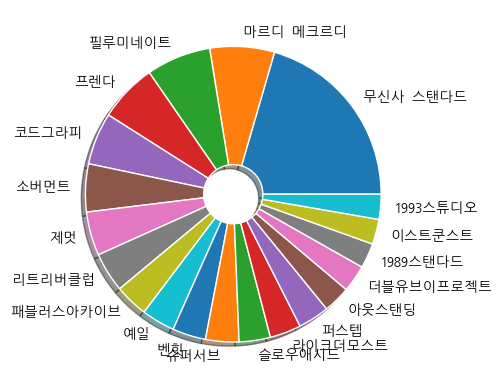

In [150]:
wedgeProps = {'width' : 0.8, 'edgecolor' : 'w', 'linewidth': 1}
pie = df_musinsa_top['브랜드'].value_counts().head(20).plot.pie(shadow=True,wedgeprops=wedgeProps)


pie.set_ylabel(None)
plt.show()


In [103]:
df_musinsa_top['랭킹'] = df_musinsa_top.index + 1

In [105]:
df_musinsa_top[['랭킹','상품 가격','세일 가격']].corr(method='pearson')

## 랭킹과 상품 가격, 세일 가격과는 별 연관이 없다

## 세일 가격과 상품 가격과의 연관성이 크다 // 상품 가격이 증가하면 대체로 세일 가격도 증가한다.


,랭킹,상품 가격,세일 가격
랭킹,1.000000,-0.023911,-0.047075
상품 가격,-0.023911,1.000000,0.741656
세일 가격,-0.047075,0.741656,1.000000


In [ ]:
df_musinsa_top[['랭킹','상품 가격','세일 가격']].corr(method='spearman')


In [ ]:
## 세일 폭과 랭킹과의 상관 관계 알아보기

df_sale = df_musinsa_top[df_musinsa_top['세일 가격'].isnull() == False]


df_sale['세일 폭'] = df_sale['상품 가격'] - df_sale['세일 가격']

In [ ]:
df_sale['세일 폭'] = df_sale['세일 폭'].astype(int)

In [170]:
df = df_sale[['랭킹','세일 폭','상품 가격','세일 가격']].corr(method='pearson')

In [ ]:
df

In [ ]:
df_musinsa_top.head(200)['브랜드'].value_counts()